# Drivers of Reddit NFL sentiment
This notebook investigates what drives the sentiment of NFL players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nba-sentiment.ipynb`.

### Short term to-do:
* Upload table of sentiment and player
* Upload joined table of covariates and sentiment
* Clean up comment matching
  * Why does JJ Watt have low comment count?
* Add salary data and Trump vote share
* Try to find some subset of data where performance is correlated with sentiment

### Long term to-do:

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

In [1]:
import json
import string
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Baltimore Ravens Buffalo Bills Cincinnati Bengals Cleveland Browns Denver Broncos Houston Texans Indianapolis Colts ' \
                        'Jacksonville Jaguars Kansas City Chiefs Los Angeles Chargers Miami Dolphins New England Patriots New York Jets ' \
                        'Oakland Raiders Pittsburgh Steelers Tennessee Titans NFL Bowl' \
                       'Arizona Cardinals Atlanta Falcons Carolina Panthers Chicago Bears Dallas Cowboys Detroit Lions Green Bay Packers ' \
                        'Los Angeles Rams Minnesota Vikings New Orleans Saints New York Giants Philadelphia Eagles San Francisco 49ers ' \
                        'Seattle Seahawks Tampa Bay Buccaneers Washington Redskins' \
                        'Goodell Belichick Lebron'.lower().split())

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [6]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously',
                 'rob']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

## 1. Load player demographic and performance data
### Demographics
#### Ethnicity
To get a list of black players, I queried Wikipedia's Categories for African American football players and Samon players. This list contained a large fraction of players, but did not label all players, nor identify white NFL players. I then supplemented this list by Googling the ethnicity of the remaining players

In [7]:
nonwiki_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players_race_unknown.csv')

In [8]:
race_nfl_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nfl_race_players.tsv', sep='\t'),
                        nonwiki_df])

#### Download demographics of recent players with weight, height, etc.
`pro-football-reference.com` has non-racial demographic data for players going back to the fifties. Here I download those players' data, and filter to recent players.

In [12]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players2010-2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()
demo_df['position'] = demo_df['position'].str.strip('()').str.lower().str.split('-').str[0]
def map_name(name):
    if '.' in name:
        return name.replace('.', ' ').replace('  ', ' ') # <- janky
    return name.split(' ')[0][0] + ' ' + name.split(' ')[1]
demo_df['player_join'] = demo_df['Player'].apply(map_name)

In [13]:
# have to manually fix some player name mappings
player_map = {'ej manuel':'ej manuel',
                         'marlon brown': 'ma brown',  'mike brown': 'mi brown', 'john brown': 'jo brown',
                         'deangelo williams': 'de williams', 'david johnson':'da johnson',
                         'trent taylor':'tr taylor', 'jj nelson': 'j j nelson',
                         'jaron brown':'ja brown', "nick o\\'leary": "n o'leary"
                         }
demo_df['player_join'] = demo_df.apply(lambda row: player_map[row['Player']] if row['Player'] in player_map else row['player_join'], axis=1)
position_map = {'fb':'rb'}
demo_df['position'] = demo_df['position'].replace(position_map)

#### Player performance
For player performance, I download data from `footballoutsiders.com`

In [14]:
#performance_df.to_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t', index = False)
performance_df = (pd.read_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t')
                    .rename(columns={'Team':'Tm'}))
performance_df['player_join'] = performance_df['Player'].str.replace('.', ' ').str.lower()

In [15]:
city_mapping = {'NE':'BOS', 'NO':'NOP', 'CAR':'CHO', 'SD':'SDG', 'LACH':'LAC', 'LARM':'LAR'}
performance_df['Tm'] = performance_df['Tm'].replace(city_mapping)

#### Team info
Here I download team performance from `pro-football-outsiders.com`

In [16]:
#team_df.to_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t', index=False)
team_df= pd.read_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t')

#### City demographics
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for NFL cities.

In [17]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [18]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combine them into a single dataframe that has performance, demographics, and city information.

In [19]:
covariates_df = (performance_df.merge(demo_df, on = ['player_join', 'position'], how='left', suffixes=('_FO', ''))
                             .merge(race_nfl_df, on='Player', how='left')
#                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
#                      .merge(vote_df, on='Tm')
                      .dropna(subset= ['start_year'])
                )
covariates_df['experience'] = covariates_df['year'] - covariates_df['start_year']
covariates_df.head(2)

,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,player_join,Player,url,start_year,end_year,height,weight,birth_date,race,total_population,metro_percent_white,metro_percent_black,experience
0,T.Brady,BOS,qb,2035,35.1,34,2.574492,1.846341,1.437475,2012,t brady,tom brady,/players/B/BradTo00.htm,2000.0,2018.0,76.0,225.0,"August 3, 1977",W,4728844,77.3,8.0,12.0
1,S.Ridley,BOS,rb,192,6.1,12,0.954130,0.613013,1.648603,2012,s ridley,stevan ridley,/players/R/RidlSt00.htm,2011.0,2018.0,71.0,220.0,"January 27, 1989",B,4728844,77.3,8.0,1.0


#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [20]:
UNIQUE_NAMES = {x.replace('\\', '') for x in set(demo_df.Player.unique())}

In [21]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'rg3'})
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Black', 'Ball', 'Brown', 'Buddy', 'Grant', 'House', 'Smart', 'Holiday', 'Love', 'Rose', 'Smart', 'Stone', 'Temple', 
                  'Wall', 'Will', 'White', 'Wear', 'Case', 'New', 'Little', 'Shorts', 'City', 'Will', 'Wise', 'Guy', 'Still', 'Long',
                  'Person', 'Petty', 'Good', 'Hand', 'Best', 'Free', 'Chance', 'Hope', 'Hurt', 'Weeks', 'Early', 'Means', 'Savage', 'Burden',
                  'Petty', 'Rob'}
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
# remove periods for some names
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [22]:
%%time
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES)
_, sep_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201709-comments_submissions.tsv')
_, oct_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201710-comments_submissions.tsv')
_, nov_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201711-comments_submissions.tsv')
_, dec_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201712-comments_submissions.tsv')
_, jan_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201801-comments_submissions.tsv')
_, feb_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201802-comments_submissions.tsv')

Loading one month of player comments
Loaded 303436 comments
Filtering to comments with text_length > 20 and text_length < 500
After filter, have 244008 comments
Chunking comments into sentences
Chunking into sentences
Chunked into 453435 sentences
Extracting named entities
Cleaning entities
Outputting 129973 sentences which have 1-2 named entities
Calculating sentiment
Returning 129973 sentences with clear player name
Loading one month of player comments
Loaded 312038 comments
Filtering to comments with text_length > 20 and text_length < 500
After filter, have 259910 comments
Chunking comments into sentences
Chunking into sentences
Chunked into 470543 sentences
Extracting named entities
Cleaning entities
Outputting 138798 sentences which have 1-2 named entities
Calculating sentiment
Returning 138798 sentences with clear player name
Loading one month of player comments
Loaded 298597 comments
Filtering to comments with text_length > 20 and text_length < 500
After filter, have 251185 comm

In [23]:
nfl2017_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2017_df.shape

(834502, 15)

In [49]:
%%time
# 34 minutes with 8 cores
import importlib
importlib.reload(ss)
nfl2017_df = ss.fuzzy_match_players(nfl2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 25min 53s


In [53]:
nfl2017_df.to_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### Save / load

In [24]:
#nba2015_df = pd.read_csv('data/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
#nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
#nba2016_df = pd.read_csv('data/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
#nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nfl2017_df = pd.read_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2017_df['named_entities'] = nfl2017_df['named_entities'].apply(literal_eval)

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [77]:
%%time
nba2017_df['fuzzy_name'] = nba2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
#nba2016_df['fuzzy_name'] = nba2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
#nba2015_df['fuzzy_name'] = nba2015_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 24.5 s


Remove players whose names have implicit sentiment

In [155]:
senti_players = ['maurice hurt', 'chris hope', 'tom savage', 'chandler burden', 'bryce petty', 'andrew luck', 'lucky whitehead', 'jahvid best']
nfl2017_df = nfl2017_df[nfl2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
#nba2016_df = nba2016_df[nba2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
#nba2015_df = nba2016_df[nba2015_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [76]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                                       'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                                       'jimmy tyler', 'jamal curry', 'jamal curry' 'london','jackson tatum', 'washington']}
name_map.update({'rodgers':'aaron rodgers',
                'kd':'kevin durant',
                 'lbj':'lebron james',
                 'lma':'lamarcus aldridge'})

In [156]:
match_df = nfl2017_df.query('fuzzy_name != "unclear"')
match_df.shape

(190325, 16)

#### First calculate the average sentiment for each player from each user

In [157]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(2)

,fuzzy_name,user,compound_mean,compound_std,comment_count
0,a'shawn robinson,AshytooClassy,0.0000,NaN,1
1,a'shawn robinson,Brookboy,0.3612,NaN,1


#### Then calculate the average sentiment to players across all users

In [158]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby('fuzzy_name')
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

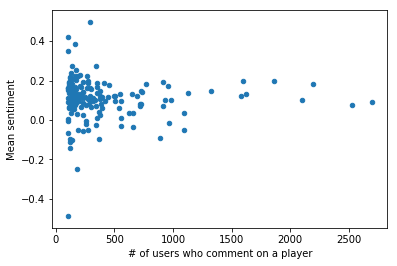

In [159]:
player_sentiment_df.query('user_count> 100').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [160]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
1480,jon weeks,0.093205,0.421378,2699
2602,steven means,0.074130,0.444883,2527
446,carson wentz,0.180723,0.389517,2194
965,early doucet,0.099975,0.434961,2103
2744,tony romo,0.197007,0.423812,1858


#### Players with lowest sentiment

In [161]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
2365,rob gronkowski,-0.486386,0.273777,108
2018,michael bennett,-0.250595,0.435006,178
711,danny trevathan,-0.141353,0.474181,117
1702,kevin haslam,-0.110763,0.446714,118
911,donald driver,-0.101735,0.490609,139


In [162]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "rob gronkowski"')

#### Players with highest sentiment

In [79]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
1174,j.j. watt,0.273541,0.337039,347
1860,lucky whitehead,0.409953,0.322337,1376
117,andrew luck,0.445603,0.304644,489
466,champ bailey,0.495389,0.333679,295
1201,jahvid best,0.619011,0.200956,1440


#### Players with highest std of sentiment

In [80]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
1210,jake locker,-0.017100,0.498049,969
2777,tress way,-0.003722,0.497811,255
1697,kevin boss,0.011808,0.482248,353
1095,gimel president,-0.029723,0.474356,560
1976,matt light,0.036692,0.473313,628


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [192]:
join_df = (player_sentiment_df#.query('user_count > 20')
                         .merge(covariates_df.query('year == 2017'), left_on = 'fuzzy_name', right_on = 'Player')
                        )

### Explore demographics relationship with sentiment

In [136]:
join_df.groupby('race').mean()

,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,start_year,end_year,height,weight,total_population,metro_percent_white,metro_percent_black,experience
race,,,,,,,,,,,,,,,,,,
B,0.134179,0.424474,127.21519,122.443038,2.059494,6.898734,0.203214,0.116320,0.324007,2017.0,2013.050633,2017.860759,72.316456,212.101266,5.114018e+06,69.159459,17.516216,3.949367
M,0.148826,0.475065,23.00000,85.000000,35.000000,5.000000,0.691648,1.789748,0.734209,2017.0,2014.000000,2018.000000,75.000000,235.000000,6.047721e+06,67.500000,20.900000,3.000000
S,0.062899,0.448999,541.00000,317.000000,37.300000,7.000000,1.750139,2.361848,1.018532,2017.0,2017.000000,2018.000000,73.000000,215.000000,2.354926e+06,87.100000,8.200000,0.000000
W,0.123538,0.430659,369.25000,383.600000,4.160000,14.350000,0.260989,0.172789,0.328838,2017.0,2009.850000,2017.625000,75.600000,229.175000,5.468817e+06,71.027778,15.263889,7.150000


#### Age / experience

Text(0,0.5,'Mean sentiment')

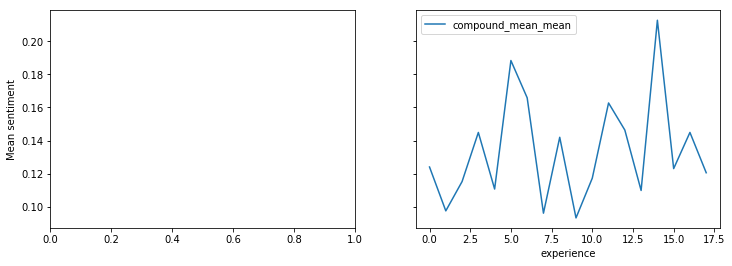

In [163]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
#join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')

#### Height

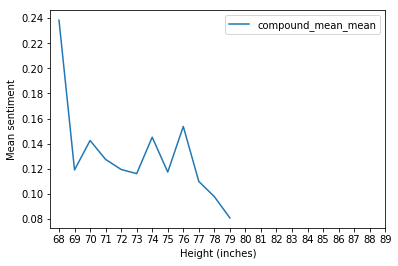

In [164]:
join_df.groupby('height').mean().reset_index().plot('height', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [165]:
join_df.groupby('position').mean().reset_index()

,position,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,start_year,end_year,height,weight,total_population,metro_percent_white,metro_percent_black,experience,youth,oldness
0,qb,0.127335,0.432073,534.812500,480.156250,2.743750,20.687500,0.098553,0.104913,0.179703,2017.0,2010.406250,2017.687500,75.218750,223.718750,5.275289e+06,70.731034,15.548276,6.593750,1.549070,3.175878
1,rb,0.131000,0.432187,82.481481,80.851852,0.377778,5.629630,0.188995,0.101627,0.280166,2017.0,2013.222222,2017.777778,70.777778,217.962963,5.562559e+06,68.708000,17.472000,3.777778,2.126110,0.936945
2,te,0.127740,0.417260,58.125000,45.062500,0.868750,4.250000,0.154365,0.005541,0.415078,2017.0,2011.000000,2017.625000,76.750000,253.125000,6.429379e+06,67.353333,16.900000,6.000000,1.418905,2.451963
3,wr,0.133776,0.422461,103.386364,153.363636,4.936364,5.386364,0.358343,0.225251,0.427133,2017.0,2012.704545,2017.909091,72.522727,200.659091,4.565720e+06,70.624390,17.182927,4.295455,1.481217,0.809730


#### Create modeling dataframe

In [193]:
join_df['youth'] = (join_df['experience'].mean() - join_df['experience']).clip(0)
join_df['oldness'] = (join_df['experience'] - join_df['experience'].mean()).clip(0)

In [194]:
join_df = join_df.query('race == "W" or race == "B"')

In [195]:
join_df['height_dummies'] = pd.cut(join_df['height'], [0, 72, 80], labels = ['short', 'tall'])

In [170]:
join_df.to_csv('nfl2017_model_data.tsv', sep='\t', index=False)

In [197]:
fit_df.head(2)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,player_join,Player,url,start_year,end_year,height,weight,birth_date,race,total_population,metro_percent_white,metro_percent_black,experience,youth,oldness,height_dummies
0,aaron rodgers,0.139293,0.448441,736,A.Rodgers,GB,qb,334,7.8,16,-0.141806,0.375436,-0.386588,2017,a rodgers,aaron rodgers,/players/R/RodgAa00.htm,2005.0,2018.0,74.0,225.0,"December 2, 1983",W,314555,88.0,1.9,12.0,0.000000,7.532338,tall
1,adam humphries,0.057700,0.802142,2,A.Humphries,TB,wr,112,5.1,1,0.006527,0.236054,-1.180475,2017,a humphries,adam humphries,/players/H/HumpAd00.htm,2015.0,2018.0,71.0,195.0,"January 24, 1993",W,2927714,78.7,12.0,2.0,2.467662,0.000000,short


### Simple models for abstract
First, a regression model with team wins, age, oldness, PER, and ethnicity

In [222]:
fit_df = join_df.copy()#.query('user_count > 200 and year == 2018')#.replace({'M':'B'})

In [223]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + z_DYAR +  height + weight + position',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [224]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.041
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.014
Date:                Sun, 07 Oct 2018   Prob (F-statistic):              0.427
Time:                        13:05:55   Log-Likelihood:                 101.61
No. Observations:                 198   AIC:                            -185.2
Df Residuals:                     189   BIC:                            -155.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3104      0.452      0.687      0.493      -0.581       1.202
position[T.rb]     0.0369      0.046      0.798      0.426      -0.054       0.128
position[T.te]     0.0736      0.045      1.630      0.105      -0.015       0.163
position[T.wr]    -0.0392      0.040     -0.986      0.326      -0.118       0.039
youth              0.0080      0.008      1.035      0.302      -0.007       0.023
oldness            0.0019      0.005      0.383      0.702      -0.008       0.012
z_DYAR            -0.0070      0.011     -0.655      0.513      -0.028       0.014
height             0.0029      0.007      0.384      0.701      -0.012       0.018
weight            -0.0019      0.001     -1.682      0.094      -0.004       0.000
==============================================================================
Omnibus:                       26.631   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.619
Skew:                          -0.425   Prob(JB):                     2.84e-21
Kurtosis:                       6.278   Cond. No.                     9.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + z_DYAR +  height + weight + position',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [226]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.039
Model:                            WLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9313
Date:                Sun, 07 Oct 2018   Prob (F-statistic):              0.492
Time:                        13:06:01   Log-Likelihood:                 120.12
No. Observations:                 194   AIC:                            -222.2
Df Residuals:                     185   BIC:                            -192.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3983      0.355      1.121      0.264      -0.303       1.100
position[T.rb]     0.0095      0.034      0.279      0.781      -0.058       0.077
position[T.te]     0.0228      0.036      0.635      0.526      -0.048       0.094
position[T.wr]     0.0028      0.027      0.104      0.917      -0.050       0.055
youth              0.0103      0.006      1.712      0.089      -0.002       0.022
oldness            0.0019      0.003      0.600      0.549      -0.004       0.008
z_DYAR            -0.0094      0.008     -1.155      0.249      -0.025       0.007
height            -0.0017      0.006     -0.282      0.779      -0.014       0.010
weight            -0.0007      0.001     -0.780      0.437      -0.002       0.001
==============================================================================
Omnibus:                       36.641   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.636
Skew:                          -0.348   Prob(JB):                     5.15e-61
Kurtosis:                       8.819   Cond. No.                     1.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### With interaction

In [176]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * white_black_diff',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [126]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.070
Model:                            WLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.363
Date:                Fri, 28 Sep 2018   Prob (F-statistic):            0.00179
Time:                        14:38:20   Log-Likelihood:                 492.99
No. Observations:                 323   AIC:                            -970.0
Df Residuals:                     315   BIC:                            -939.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1118      0.017      6.412      0.000       0.077       0.146
C(Race)[T.W]                     -0.0266      0.023     -1.133      0.258      -0.073       0.020
youth                             0.0073      0.002      4.129      0.000       0.004       0.011
oldness                           0.0020      0.001      1.765      0.079      -0.000       0.004
Wins                              0.0001      0.000      0.537      0.592      -0.000       0.001
PER                               0.0010      0.001      1.841      0.067   -6.95e-05       0.002
white_black_diff                 -0.0001      0.000     -0.645      0.519      -0.001       0.000
C(Race)[T.W]:white_black_diff     0.0007      0.000      1.593      0.112      -0.000       0.001
==============================================================================
Omnibus:                       58.807   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.801
Skew:                          -0.907   Prob(JB):                     1.45e-29
Kurtosis:                       5.565   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * clinton_vote_lead',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [128]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.077
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.769
Date:                Fri, 28 Sep 2018   Prob (F-statistic):           0.000610
Time:                        14:38:50   Log-Likelihood:                 494.34
No. Observations:                 323   AIC:                            -972.7
Df Residuals:                     315   BIC:                            -942.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0904      0.015      5.852      0.000       0.060       0.121
C(Race)[T.W]                       0.0329      0.016      2.115      0.035       0.002       0.063
youth                              0.0074      0.002      4.234      0.000       0.004       0.011
oldness                            0.0020      0.001      1.768      0.078      -0.000       0.004
Wins                               0.0001      0.000      0.573      0.567      -0.000       0.001
PER                                0.0010      0.001      1.745      0.082      -0.000       0.002
clinton_vote_lead                  0.0381      0.018      2.150      0.032       0.003       0.073
C(Race)[T.W]:clinton_vote_lead    -0.0622      0.036     -1.739      0.083      -0.133       0.008
==============================================================================
Omnibus:                       57.177   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.306
Skew:                          -0.894   Prob(JB):                     6.17e-28
Kurtosis:                       5.473   Cond. No.                         617.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""